In [1]:
import sys
sys.path.append('..')

In [2]:
import os
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import lightning.pytorch as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from peft import LoraConfig, get_peft_model

import esm

2024-12-19 10:56:56.051006: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-19 10:56:56.053433: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-19 10:56:56.059108: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-19 10:56:56.070066: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-19 10:56:56.070087: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting t

In [4]:
from DomainPrediction.utils import helper
from DomainPrediction.eval import metrics
from DomainPrediction.esm.esm2 import ESM2

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from scipy import stats
from sklearn.model_selection import train_test_split

In [6]:
import warnings

warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")
warnings.filterwarnings("ignore", ".*Set a lower value for log_every_n_steps*")

#### Define Functions

In [7]:
esm2 = ESM2(model_path='/data/users/kgeorge/workspace/esm2/checkpoints/esm2_t33_650M_UR50D.pt', device='gpu')

In [8]:
def get_embeddings_mean(sequences):
    embeddings = []
    for seq in tqdm(sequences):
        rep = esm2.get_res(sequence=seq)
        embeddings.append(rep['representations'][33][:,1:-1,:].mean(1).cpu().numpy())

    embeddings = np.concatenate(embeddings, axis=0)

    return embeddings

def get_embeddings_mean_batch(sequences, batch_size=3):
    embeddings = []
    for i in tqdm(range(0, len(sequences), batch_size)):
        seqs = sequences[i:i+batch_size]
        rep, batch_lens = esm2.get_res_batch(sequences=seqs)
        assert (batch_lens == batch_lens[0]).all() == True
        embeddings.append(rep['representations'][33][:,1:-1,:].mean(1).cpu().numpy())

    embeddings = np.concatenate(embeddings, axis=0)

    return embeddings

def get_embeddings_full(sequences):
    embeddings = []
    for seq in tqdm(sequences):
        rep = esm2.get_res(sequence=seq)
        embeddings.append(rep['representations'][33][:,1:-1,:].cpu().numpy()[0])

    return embeddings

In [9]:
class RFSurrogate():
    def __init__(self) -> None:

        self.model = RandomForestRegressor(n_estimators=100, criterion='friedman_mse', max_depth=None, min_samples_split=2,
                                            min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=1.0,
                                            max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False,
                                            n_jobs=None, random_state=1, verbose=0, warm_start=False, ccp_alpha=0.0,
                                            max_samples=None)
    
    def train(self, X, y, val=True, debug=True):
        '''
            X - embeddings from esm2
            X - shape (n, features)
            y - shape (n, )
        '''
        if val:
            idx = np.arange(X.shape[0])
            train_idx, val_idx = train_test_split(idx, test_size=0.2)
            _ = self.model.fit(X[train_idx], y[train_idx])

            if debug:
                self.print_eval(X[train_idx], y[train_idx], label='train')
                self.print_eval(X[val_idx], y[val_idx], label='val')
        else:
            _ = self.model.fit(X, y)
            if debug:
                self.print_eval(X, y, label='train')
    
    def print_eval(self, X, y, label='set'):
        ypred = self.model.predict(X)
        mse = mean_squared_error(ypred, y)
        corr = stats.spearmanr(ypred, y)

        print(f'{label}: mse = {mse}, spearman correlation = {corr.statistic}')

    def predict(self, X):

        return self.model.predict(X)

In [10]:
class RidgeSurrogate():
    def __init__(self) -> None:

        self.model = Ridge(alpha=1.0, fit_intercept=True, random_state=1)
    
    def train(self, X, y, val=True, debug=True):
        '''
            X - embeddings from esm2
            X - shape (n, features)
            y - shape (n, )
        '''
        if val:
            idx = np.arange(X.shape[0])
            train_idx, val_idx = train_test_split(idx, test_size=0.2)
            _ = self.model.fit(X[train_idx], y[train_idx])

            if debug:
                self.print_eval(X[train_idx], y[train_idx], label='train')
                self.print_eval(X[val_idx], y[val_idx], label='val')
        else:
            _ = self.model.fit(X, y)
            if debug:
                self.print_eval(X, y, label='train')
    
    def print_eval(self, X, y, label='set'):
        ypred = self.model.predict(X)
        mse = mean_squared_error(ypred, y)
        corr = stats.spearmanr(ypred, y)

        print(f'{label}: mse = {mse}, spearman correlation = {corr.statistic}')

    def predict(self, X):

        return self.model.predict(X)

In [11]:
class ProteinFunDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class MLPSurrogate(pl.LightningModule):
    def __init__(self, inp_size=1280, hidden_size=512, 
                 config={'epoch': 10, 
                         'batch_size': 16}
                ) -> None:
        super().__init__()
        self.config = config
        # self.mlp = nn.Sequential(
        #     nn.Linear(inp_size, hidden_size),
        #     nn.ReLU(),
        #     nn.Linear(hidden_size, 1)
        # )
        self.mlp = nn.Sequential(
            nn.LayerNorm(1280),
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )
        self.accumulate_batch_loss_train = []
        self.accumulate_batch_loss_val = []
        self.debug=True

    def forward(self, x):
        x = self.mlp(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        # y_hat = self.mlp(x)
        # print(y_hat)
        # print(y_hat.flatten())
        # print(y)
        # loss = nn.functional.mse_loss(y_hat.flatten(), y)
        loss = nn.functional.mse_loss(y_hat.flatten(), y)
        self.log("train/loss", loss, on_step=True, on_epoch=True)
        self.accumulate_batch_loss_train.append(loss.item())
        # print(loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        # y_hat = self.mlp(x)
        loss = nn.functional.mse_loss(y_hat.flatten(), y)
        self.log("val/loss", loss, on_step=True, on_epoch=True)
        self.accumulate_batch_loss_val.append(loss.item())
    
    @staticmethod
    def trainmodel(model, X, y, val=True, debug=True):
        '''
            X - embeddings from esm2
            X - shape (n, features)
            y - shape (n, )
        '''
        model.debug = debug
        if val:
            idx = np.arange(X.shape[0])
            train_idx, val_idx = train_test_split(idx, test_size=0.2)
            train_dataset = ProteinFunDataset(X[train_idx], y[train_idx])
            val_dataset = ProteinFunDataset(X[val_idx], y[val_idx])
            train_loader = DataLoader(train_dataset, batch_size=model.config['batch_size'], shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=model.config['batch_size'], shuffle=False)

            earlystopping_callback = EarlyStopping(monitor="val/loss", patience=5, verbose=False, mode="min")

            trainer = pl.Trainer(max_epochs=model.config['epoch'], callbacks=[earlystopping_callback],
                                 accelerator="auto",
                                 enable_progress_bar=False,
                                 enable_model_summary=False
                                 )
            trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

            ## Needs to change - we need to load the least val loss model
            y_pred = model.predict(X[val_idx])
            val_mse = mean_squared_error(y_pred, y[val_idx])
            print(f'Train end val mse: {val_mse}')

        else:
            raise Exception("Needs Fix")
            train_dataset = ProteinFunDataset(X, y)
            train_loader = DataLoader(train_dataset)

            trainer = pl.Trainer(max_epochs=95, 
                                 enable_progress_bar=False,
                                 accelerator="auto"
                                 )
            trainer.fit(model=model, train_dataloaders=train_loader)

    def on_train_epoch_start(self):
        self.accumulate_batch_loss_train.clear()
        self.accumulate_batch_loss_val.clear()
    
    def on_train_epoch_end(self):
        if self.current_epoch % self.config['print_every_n_epoch'] == 0 and self.debug:
            print(f'Epoch: {self.current_epoch}: train mse: {np.mean(self.accumulate_batch_loss_train)} val mse: {np.mean(self.accumulate_batch_loss_val)}')

    def on_train_end(self):
        print(f'Epoch: {self.current_epoch}: train mse: {np.mean(self.accumulate_batch_loss_train)} val mse: {np.mean(self.accumulate_batch_loss_val)}')

    def predict(self, X):
        '''
            X is numpy array
        '''
        with torch.no_grad():
            y = self(torch.tensor(X))
        return y.numpy().flatten()
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [12]:
class ESM2Regression(nn.Module):
    def __init__(self, model_path) -> None:
        super().__init__()
        self.esm2, self.alphabet = esm.pretrained.load_model_and_alphabet(model_path)
        self.batch_converter = self.alphabet.get_batch_converter()

        self.mlp = nn.Sequential(
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

        self.tok_to_idx = self.alphabet.tok_to_idx
        self.idx_to_tok = {v:k for k,v in self.tok_to_idx.items()}

    def forward(self, batch_tokens):
        rep = self.esm2(batch_tokens, repr_layers=[33], return_contacts=True)
        embedding = rep['representations'][33].mean(1)

        pred = self.mlp(embedding)

        return pred
    
class ESM2LoRASurrogate(pl.LightningModule):
    def __init__(self, config, device='gpu') -> None:
        super().__init__()
        self.config = config
        esm2_regressor = ESM2Regression(model_path='/data/users/kgeorge/workspace/esm2/checkpoints/esm2_t33_650M_UR50D.pt')
        config = LoraConfig(
            r=4, 
            lora_alpha=1,
            target_modules=["k_proj", "q_proj", "v_proj", "out_proj", "fc1", "fc2"],
            lora_dropout=0.1,
            bias="all",
        )

        self.model = get_peft_model(esm2_regressor, config)
        for name, param in self.model.named_parameters():
            if 'mlp' in name:
                param.requires_grad = True
        
        self.__device = device

        if self.__device == 'gpu':
            self.model.cuda()

        self.accumulate_batch_loss_train = []
        self.accumulate_batch_loss_val = []
        self.debug=True

    def print_trainable_parameters(self):
        self.model.print_trainable_parameters()
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        data = [
            (fun, seq) for (seq, fun) in zip(x, y)
            ]
        batch_labels, batch_strs, batch_tokens = self.model.batch_converter(data)
        batch_lens = (batch_tokens != self.model.alphabet.padding_idx).sum(1)

        if self.__device == 'gpu':
            batch_tokens = batch_tokens.cuda()

        y_hat = self.model(batch_tokens)
        loss = nn.functional.mse_loss(y_hat.flatten(), y)
        self.log("train/loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.accumulate_batch_loss_train.append(loss.item())

        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        data = [
            (fun, seq) for (seq, fun) in zip(x, y)
            ]
        batch_labels, batch_strs, batch_tokens = self.model.batch_converter(data)
        batch_lens = (batch_tokens != self.model.alphabet.padding_idx).sum(1)

        if self.__device == 'gpu':
            batch_tokens = batch_tokens.cuda()

        y_hat = self.model(batch_tokens)
        loss = nn.functional.mse_loss(y_hat.flatten(), y)
        self.log("val/loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.accumulate_batch_loss_val.append(loss.item())
    
    @staticmethod
    def trainmodel(model, X, y, val=True, debug=True):
        '''
            X - embeddings from esm2
            X - shape (n, features)
            y - shape (n, )
        '''
        model.debug = debug
        if val:
            batch_size = 1
            idx = np.arange(X.shape[0])
            train_idx, val_idx = train_test_split(idx, test_size=0.2)
            train_dataset = ProteinFunDataset(X[train_idx], y[train_idx])
            val_dataset = ProteinFunDataset(X[val_idx], y[val_idx])
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

            earlystopping_callback = EarlyStopping(monitor="val/loss", patience=5, verbose=False, mode="min")

            trainer = pl.Trainer(max_epochs=model.config['epoch'], callbacks=[earlystopping_callback],
                                 accelerator="auto",
                                 enable_progress_bar=False,
                                 enable_model_summary=False,
                                 precision="16-mixed",
                                 accumulate_grad_batches=model.config['batch_size']
                                 )
            trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

            ## Needs to change - we need to load the least val loss model
            # y_pred = validation_step(X[val_idx])
            # val_mse = mean_squared_error(y_pred, y[val_idx])
            # print(f'Train end val mse: {val_mse}')

        else:
            raise Exception("Needs Fix")

    def on_train_epoch_start(self):
        self.accumulate_batch_loss_train.clear()
        self.accumulate_batch_loss_val.clear()
    
    def on_train_epoch_end(self):
        if self.current_epoch % self.config['print_every_n_epoch'] == 0 and self.debug:
            print(f'Epoch: {self.current_epoch}: train mse: {np.mean(self.accumulate_batch_loss_train)} val mse: {np.mean(self.accumulate_batch_loss_val)}')

    def on_train_end(self):
        if self.debug:
            print(f'Epoch: {self.current_epoch}: train mse: {np.mean(self.accumulate_batch_loss_train)} val mse: {np.mean(self.accumulate_batch_loss_val)}')

    def predict(self, X):
        '''
            X is numpy array
        '''
        with torch.no_grad():
            data = [
                (f'p{i+1}', seq) for i, seq in enumerate(X)
                ]
            batch_labels, batch_strs, batch_tokens = self.model.batch_converter(data)
            batch_lens = (batch_tokens != self.model.alphabet.padding_idx).sum(1)

            if not next(self.model.parameters()).is_cuda:
                self.model.cuda()

            assert next(self.model.parameters()).is_cuda

            batch_tokens = batch_tokens.cuda()

            pred = []
            for i in tqdm(range(0, batch_tokens.shape[0])):
                y_pred = self.model(batch_tokens[i:i+1])
                pred.append(y_pred.cpu().numpy().flatten())
        
        return np.concatenate(pred)
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=0.0001)

#### Load Data

In [18]:
root = '../..'
data_path = os.path.join(root, 'Data/al_test_experiments/Evolvepro')

In [19]:
file_name = os.path.join(data_path, 'brenan.csv')
df = pd.read_csv(file_name)

In [20]:
df.shape

(6810, 4)

In [21]:
df.head()

,pos,seq,function,function_scaled
0,2,MCAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...,-4.176315,0.265834
1,2,MDAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...,-1.918793,0.397712
2,2,MEAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...,-3.165665,0.324874
3,2,MFAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...,-6.126452,0.151913
4,2,MGAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...,-4.255602,0.261203


#### Tests

In [17]:
# embeddings = get_embeddings_mean(df['seq'][:100])

In [18]:
# embeddings.shape

In [19]:
# config = {'epoch': 5, 'batch_size': 8, 'print_every_n_epoch': 1}
# surrogate = ESM2LoRASurrogate(config=config)

In [20]:
# surrogate.print_trainable_parameters()

In [21]:
# next(surrogate.parameters()).is_cuda

In [22]:
# ESM2LoRASurrogate.trainmodel(model=surrogate, X=df['seq'][:100].to_numpy(), y=df['function'][:100].to_numpy().astype(np.float32))

In [23]:
# next(surrogate.parameters()).is_cuda

In [24]:
# with torch.no_grad():
#     data = [
#         (f'p{i+1}', seq) for i, seq in enumerate(df['seq'].to_numpy())
#         ]
#     batch_labels, batch_strs, batch_tokens = surrogate.model.batch_converter(data)
#     batch_lens = (batch_tokens != surrogate.model.alphabet.padding_idx).sum(1)

#     if not next(surrogate.parameters()).is_cuda:
#         surrogate.model.cuda()

#     assert next(surrogate.parameters()).is_cuda

#     batch_tokens = batch_tokens.cuda()

#     pred = []
#     # for i in tqdm(range(0, batch_tokens.shape[0], 10)):
#     for i in tqdm(range(0, batch_tokens.shape[0])):
#         y_pred = surrogate.model(batch_tokens[i:i+1])
#         pred.append(y_pred.cpu().numpy().flatten())

In [25]:
# plt.plot(df['function'][:1000].to_numpy(), surrogate.predict(embeddings), '.')
# # plt.ylim((0,0.6))
# # plt.xlim((0,0.6))
# mean_squared_error(df['function'][:1000].to_numpy(), surrogate.predict(embeddings))

#### AL Cycle

In [26]:
# embeddings = get_embeddings_mean(df['seq'])
# file_name = os.path.join(data_path, 'brenan_embeddings.npy')
# np.save(file_name, embeddings)

In [27]:
file_name = os.path.join(data_path, 'brenan_embeddings.npy')
embeddings = np.load(file_name)

In [28]:
embeddings.shape

(6810, 1280)

In [29]:
surrogate = RFSurrogate()
# surrogate = RidgeSurrogate()
# config = {'epoch': 100, 'batch_size': 16, 'print_every_n_epoch': 50}
# surrogate = MLPSurrogate(config=config)

In [30]:
import logging
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)

In [ ]:
### Needs fixing scaled and function

In [31]:
## Only sample initial points with function < 0.3

df_al = df.copy()
df_al['round'] = -1

rounds = 10
thresh = 1.0
n_sample = 16
high_thresh = 0.656
df_al['high'] = 0
df_al.loc[list(df_al.loc[(df_al['round'] == -1) & (df_al['function'] > high_thresh)].index), 'high'] = 1
index = list(df_al.loc[(df_al['round'] == -1) & (df_al['function'] < thresh)].index)
sample_index = random.sample(index, n_sample)

In [32]:
print(f"# of high fitness proteins {df_al['high'].sum()}")

# of high fitness proteins 77


In [33]:
for i in range(rounds):
    print(' ')
    print(f'Round {i}')

    df_al.loc[sample_index, 'round'] = i
    train_index = list(df_al.loc[df_al['round'] != -1].index) ## whatever was selected
    X = embeddings[train_index]
    X_seq = df_al.loc[train_index, 'seq'].to_numpy()
    y = df_al.loc[train_index, 'function'].to_numpy().astype(np.float32)
    
    assert X.shape[0] == y.shape[0] == X_seq.shape[0]
    print(f'number of samples for training: {X.shape[0]}')

    surrogate.train(X, y)
    ypred = surrogate.predict(embeddings)

    # config = {'epoch': 100, 'batch_size': 16, 'print_every_n_epoch': 50}
    # surrogate = MLPSurrogate(config=config)
    # MLPSurrogate.trainmodel(model=surrogate, X=X, y=y)
    # ypred = surrogate.predict(embeddings)

    # config = {'epoch': 5, 'batch_size': 8, 'print_every_n_epoch': 1}
    # surrogate = ESM2LoRASurrogate(config=config)
    # assert next(surrogate.parameters()).is_cuda
    # ESM2LoRASurrogate.trainmodel(model=surrogate, X=X_seq, y=y)
    # ypred = surrogate.predict(df_al['seq'].to_numpy()[:])
    # surrogate.model.cpu()
    # surrogate = None
    # torch.cuda.empty_cache() 

    df_al[f'round_{i}_pred'] = ypred

    sample_index = df_al.loc[df_al['round']==-1, f'round_{i}_pred'].nlargest(n_sample).index

 
Round 0
number of samples for training: 16
train: mse = 0.0016059879556336552, spearman correlation = 0.9720279720279721
val: mse = 0.014344472771626923, spearman correlation = 0.39999999999999997
 
Round 1
number of samples for training: 32
train: mse = 0.001289989194155215, spearman correlation = 0.9507692307692308
val: mse = 0.0034211463024768863, spearman correlation = 0.4642857142857144
 
Round 2
number of samples for training: 48
train: mse = 0.0008150063183179176, spearman correlation = 0.9722070248386038
val: mse = 0.010327807808163517, spearman correlation = 0.18787878787878787
 
Round 3
number of samples for training: 64
train: mse = 0.0010547697011436218, spearman correlation = 0.9704072398190046
val: mse = 0.0038955178610093556, spearman correlation = 0.3736263736263736
 
Round 4
number of samples for training: 80
train: mse = 0.0008632443796937273, spearman correlation = 0.9713827838827838
val: mse = 0.009827862208855509, spearman correlation = 0.31764705882352945
 
Roun

In [34]:
df_al.head()

,seq,function,round,high,round_0_pred,round_1_pred,round_2_pred,round_3_pred,round_4_pred,round_5_pred,round_6_pred,round_7_pred,round_8_pred,round_9_pred
0,MCAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...,0.265834,-1,0,0.302627,0.301618,0.338998,0.284413,0.281771,0.315493,0.305703,0.309473,0.294695,0.288520
1,MDAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...,0.397712,-1,0,0.322158,0.302536,0.269328,0.331394,0.298926,0.321020,0.313478,0.283009,0.270219,0.327133
2,MEAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...,0.324874,-1,0,0.310140,0.349119,0.326491,0.332105,0.361193,0.358811,0.323774,0.293524,0.300898,0.337007
3,MFAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...,0.151913,-1,0,0.335522,0.270171,0.258553,0.263041,0.285284,0.279112,0.288810,0.272759,0.263697,0.312146
4,MGAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...,0.261203,-1,0,0.285112,0.259712,0.305932,0.247108,0.254751,0.304507,0.278470,0.267154,0.291707,0.294560


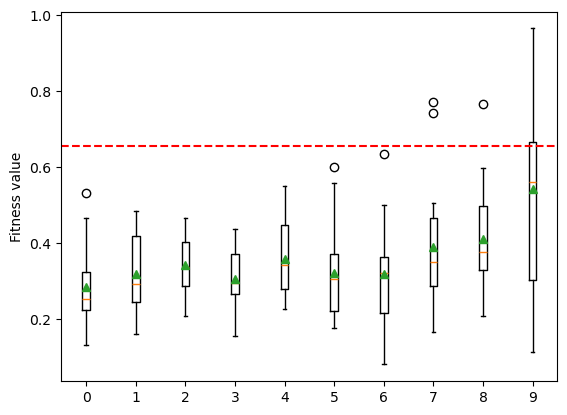

In [35]:
fig, ax = plt.subplots()
ax.set_ylabel('Fitness value')
for i, _round in enumerate(range(rounds)):
    ax.boxplot(df_al.loc[df_al['round']==_round, 'function'], positions=[i], labels=[_round], showmeans=True)
ax.axhline(high_thresh, ls='--', color='red')

Text(0, 0.5, '% high fitness canditates')

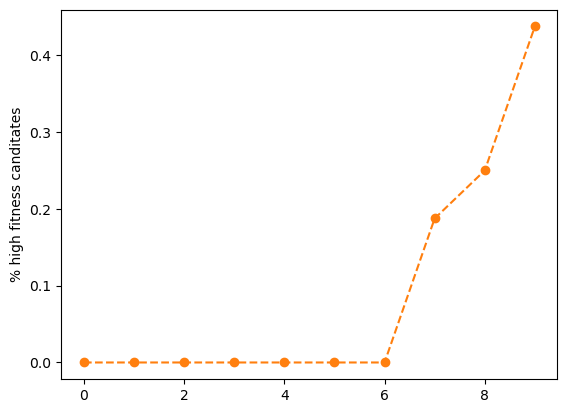

In [37]:
fig, ax = plt.subplots()

counts = []
for i in range(rounds):
    counts.append(df_al.loc[df_al[f'round_{i}_pred'].sort_values(ascending=False).head(16).index, 'high'].mean())

counts = np.array(counts)

ax.plot(counts, 'o', ls='--', color='tab:orange')
ax.set_ylabel(r'% high fitness canditates')

Text(0, 0.5, '% high fitness canditates')

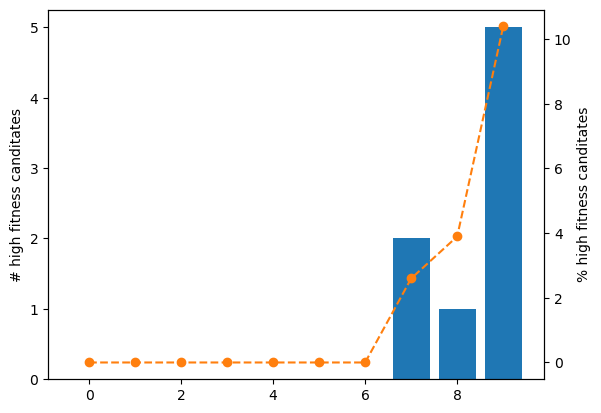

In [38]:
fig, ax = plt.subplots()

counts = []
for i in range(rounds):
    counts.append(df_al.loc[df_al['round']==i, 'high'].sum())

counts = np.array(counts)
ax.bar(np.arange(10), counts)
ax.set_ylabel('# high fitness canditates')

ax2 = ax.twinx()
ax2.plot(np.cumsum(counts)*100/df_al['high'].sum(), 'o', ls='--', color='tab:orange')
ax2.set_ylabel(r'% high fitness canditates')

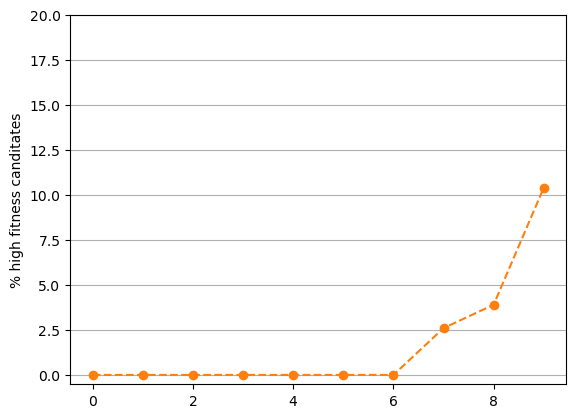

In [39]:
fig, ax = plt.subplots()
ax.grid(axis='y')
ax.plot(np.arange(10), np.cumsum(counts)*100/df_al['high'].sum(),  marker='o', ls='--', color='tab:orange')
ax.set_ylabel(r'% high fitness canditates')
ax.set_ylim(top=20)
plt.show()

In [72]:
found_hits = []
n_exp = 10
for _n in tqdm(range(n_exp)):

    df_al = df.copy()
    df_al['round'] = -1

    rounds = 10
    thresh = 1.0 ## thresh
    n_sample = 16
    high_thresh = 0.656
    df_al['high'] = 0
    df_al.loc[list(df_al.loc[(df_al['round'] == -1) & (df_al['function'] > high_thresh)].index), 'high'] = 1
    index = list(df_al.loc[(df_al['round'] == -1) & (df_al['function'] < thresh)].index)
    random.seed(_n)
    sample_index = random.sample(index, n_sample)

    for i in range(rounds):
        df_al.loc[sample_index, 'round'] = i
        train_index = list(df_al.loc[df_al['round'] != -1].index) ## whatever was selected
        X = embeddings[train_index]
        X_seq = df_al.loc[train_index, 'seq'].to_numpy()
        y = df_al.loc[train_index, 'function'].to_numpy().astype(np.float32)
        
        assert X.shape[0] == y.shape[0]

        surrogate.train(X, y, debug=False)
        ypred = surrogate.predict(embeddings)
        
        # config = {'epoch': 100, 'batch_size': 16, 'print_every_n_epoch': 50}
        # surrogate = MLPSurrogate(config=config)
        # MLPSurrogate.trainmodel(model=surrogate, X=X, y=y, debug=False)
        # ypred = surrogate.predict(embeddings)

        # config = {'epoch': 5, 'batch_size': 8, 'print_every_n_epoch': 1}
        # surrogate = ESM2LoRASurrogate(config=config)
        # assert next(surrogate.parameters()).is_cuda
        # ESM2LoRASurrogate.trainmodel(model=surrogate, X=X_seq, y=y, debug=False)
        # ypred = surrogate.predict(df_al['seq'].to_numpy())
        # surrogate.model.cpu()
        # surrogate = None
        # torch.cuda.empty_cache() 

        df_al[f'round_{i}_pred'] = ypred

        sample_index = df_al.loc[df_al['round']==-1, f'round_{i}_pred'].nlargest(n_sample).index

    hits = []
    for i in range(rounds):
        # hits.append(df_al.loc[df_al['round']==i, 'high'].sum())
        hits.append(df_al.loc[df_al[f'round_{i}_pred'].sort_values(ascending=False).head(16).index, 'high'].mean())

    found_hits.append(hits)

100%|██████████| 10/10 [02:58<00:00, 17.86s/it]


In [73]:
## reset train weights
## revove this print

In [74]:
# save info all runs as df

In [75]:
# found_hits_cum = np.cumsum(np.array(found_hits), axis=1)*100/df_al['high'].sum()

In [76]:
found_hits_cum = np.array(found_hits)

In [77]:
found_hits_cum

array([[0.    , 0.0625, 0.375 , 0.4375, 0.5625, 0.6875, 0.75  , 0.75  ,
        0.6875, 0.8125],
       [0.0625, 0.1875, 0.375 , 0.625 , 0.75  , 0.75  , 0.875 , 0.8125,
        0.9375, 0.875 ],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.125 ,
        0.25  , 0.3125],
       [0.375 , 0.375 , 0.625 , 0.625 , 0.875 , 0.875 , 0.875 , 0.875 ,
        0.8125, 0.9375],
       [0.    , 0.    , 0.    , 0.    , 0.3125, 0.375 , 0.8125, 0.8125,
        0.8125, 0.75  ],
       [0.0625, 0.0625, 0.375 , 0.5625, 0.6875, 0.875 , 0.8125, 0.8125,
        0.8125, 0.875 ],
       [0.125 , 0.1875, 0.5625, 0.75  , 0.875 , 0.8125, 0.875 , 0.875 ,
        0.875 , 0.9375],
       [0.    , 0.1875, 0.25  , 0.25  , 0.25  , 0.5   , 0.875 , 0.875 ,
        0.875 , 0.875 ],
       [0.    , 0.0625, 0.5   , 0.6875, 0.6875, 0.6875, 0.8125, 0.8125,
        0.875 , 0.875 ],
       [0.125 , 0.375 , 0.625 , 0.75  , 0.8125, 0.8125, 0.625 , 0.75  ,
        0.875 , 0.875 ]])

In [67]:
# np.cumsum(np.array(found_hits), axis=1)

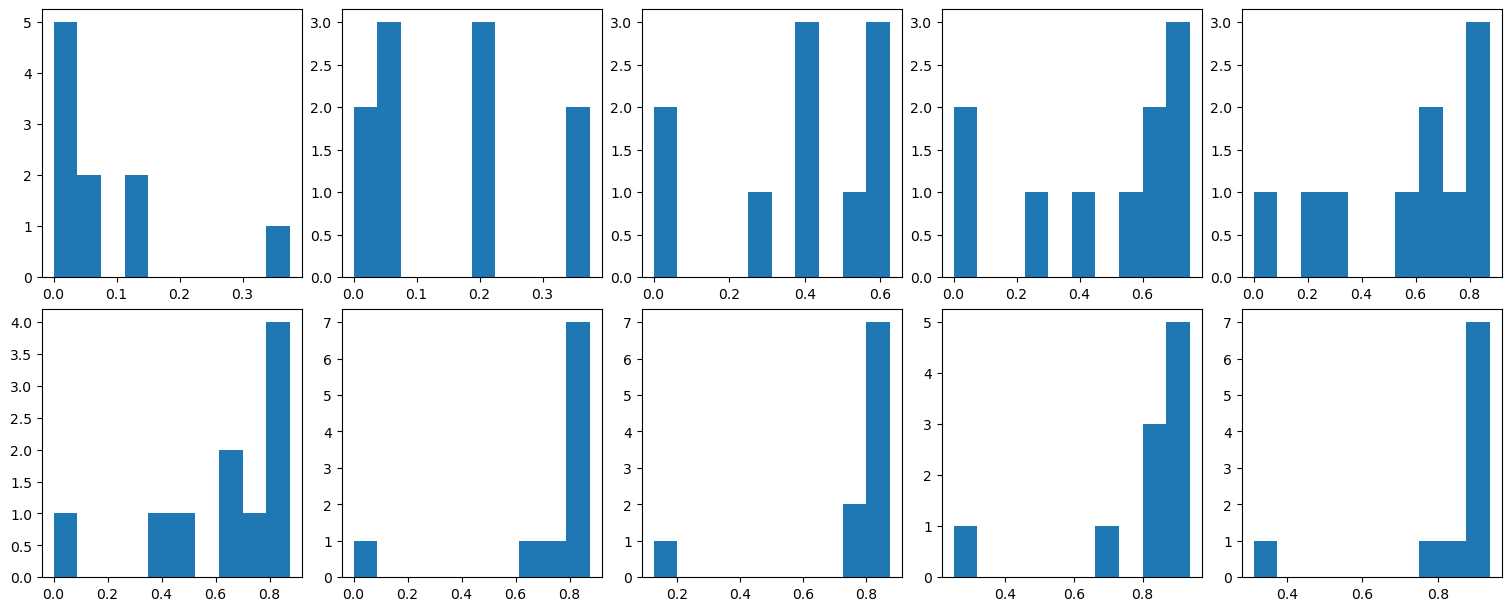

In [78]:
fig, axs = plt.subplots(2, 5, figsize=(15,6), layout='constrained')
for i, ax in enumerate(axs.reshape(-1)):
    ax.hist(found_hits_cum[:, i]) 

In [79]:
# found_hits_mean_ = []
# ci_lower_ = []
# ci_upper_ = []
# for i in range(found_hits_cum.shape[1]):
#     if i == 0:
#         found_hits_mean_.append(0)
#         ci_lower_.append(0)
#         ci_upper_.append(0)
#     else:
#         alpha, loc, beta = stats.gamma.fit(found_hits_cum[:,i])
#         found_hits_mean_.append(stats.gamma.mean(alpha, loc, beta))
#         confidence = 1 - 0.95
#         lower_bound = stats.gamma.ppf(confidence / 2, alpha, loc=loc, scale=beta)
#         upper_bound = stats.gamma.ppf(1 - confidence / 2, alpha, loc=loc, scale=beta)
#         ci_lower_.append(lower_bound)
#         ci_upper_.append(upper_bound)

In [70]:
# found_hits_mean = found_hits_cum.mean(0)
# found_hits_sem = stats.sem(found_hits_cum, axis=0)
# ci = stats.norm.interval(confidence=0.95,  
#                         loc=found_hits_mean, 
#                         scale=found_hits_sem)

In [ ]:
found_hits_mean = found_hits_cum.mean(0)
found_hits_sem = stats.sem(found_hits_cum, axis=0)
ci = stats.norm.interval(confidence=0.95,  
                        loc=found_hits_mean, 
                        scale=found_hits_sem)

In [ ]:
fig, ax = plt.subplots()
ax.grid(axis='y')
ax.plot(np.arange(10), found_hits_mean,  marker='o', ls='--', color='tab:orange')
ax.fill_between(np.arange(10), ci[0], ci[1], color='tab:orange', alpha=0.2)
ax.set_ylabel(r'% high fitness canditates')
ax.set_ylim(top=20)
plt.show()

In [ ]:
# plt.plot(np.arange(10), found_hits_mean, label='Mean Line', color='blue')
# plt.fill_between(np.arange(10), ci[0], ci[1], color='blue', alpha=0.2, label='Confidence Interval')
# plt.plot(np.arange(10), found_hits_mean_, label='Mean Line', color='green')
# plt.fill_between(np.arange(10), ci_lower_, ci_upper_, color='green', alpha=0.2, label='Confidence Interval')

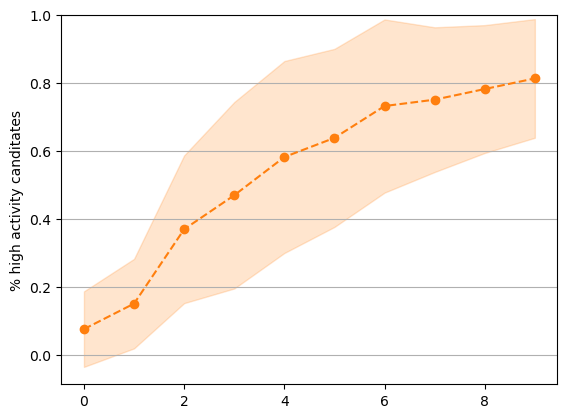

In [82]:
found_hits_mean = found_hits_cum.mean(0)
found_hits_std = found_hits_cum.std(0)

fig, ax = plt.subplots()
ax.grid(axis='y')
ax.plot(np.arange(10), found_hits_mean, marker='o', ls='--',  color='tab:orange')
ax.fill_between(np.arange(10), found_hits_mean-found_hits_std, found_hits_mean+found_hits_std, color='tab:orange', alpha=0.2)
ax.set_ylabel(r'% high activity canditates')
ax.set_ylim(top=1.0)
plt.show()